# Kaggle - Titanic: Machine Learning from Disaster

Version history:
- v1.0 Initial version
- v1.1
 + Empty ages are filled with a random number between (mean - standard deviation) and (mean + standard deviation)
 + Convert Pclass in a categorical field
 + Add noise variables to create a more generic model
- v1.2
 + Cross validation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns # Used in distribution graphics
import matplotlib.pyplot as plt # Used in distribution graphics

# Cross validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

%matplotlib inline

For this competition we will work with two files:
- train.csv --> The training set
 + PassengerId - a unique identifier for each passenger
 + Survived - 0=No 1=Yes
 + Pclass - 1 = 1st(Upper), 2 = 2nd(Middle), 3 = 3rd(Lower)
 + Name - name of the passenger
 + Sex - male/female
 + Age - age of the passenger in years. Fractional if less than 1. And x.5 if estimated
 + SibSp - number of siblings/spouse
 + Parch - number of parents/children
 + Ticket - ticket number
 + Fare - price of the ticket
 + Cabin - cabin number
 + Embarked - port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)
- test.csv --> The test set
 + PassengerId - a unique identifier for each passenger
 + Pclass - 1 = 1st(Upper), 2 = 2nd(Middle), 3 = 3rd(Lower)
 + Name - name of the passenger
 + Sex - male/female
 + Age - age of the passenger in years. Fractional if less than 1. And x.5 if estimated
 + SibSp - number of siblings/spouse
 + Parch - number of parents/children
 + Ticket - ticket number
 + Fare - price of the ticket
 + Cabin - cabin number
 + Embarked - port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

In [2]:
train_df = pd.read_csv("./train.csv")

In [3]:
train_df.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
128,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C
416,417,1,2,"Drew, Mrs. James Vivian (Lulu Thorne Christian)",female,34.0,1,1,28220,32.5000,NaN,S
335,336,0,3,"Denkoff, Mr. Mitto",male,NaN,0,0,349225,7.8958,NaN,S
656,657,0,3,"Radeff, Mr. Alexander",male,NaN,0,0,349223,7.8958,NaN,S
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0000,NaN,S
375,376,1,1,"Meyer, Mrs. Edgar Joseph (Leila Saks)",female,NaN,1,0,PC 17604,82.1708,NaN,C
150,151,0,2,"Bateman, Rev. Robert James",male,51.0,0,0,S.O.P. 1166,12.5250,NaN,S
293,294,0,3,"Haas, Miss. Aloisia",female,24.0,0,0,349236,8.8500,NaN,S
681,682,1,1,"Hassab, Mr. Hammad",male,27.0,0,0,PC 17572,76.7292,D49,C


Size of the data

In [4]:
train_df.shape

(891, 12)

Statistical description of the data (only numerical fields)

In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- Age is null in some rows

Statistical description of the data (categorical fields)

In [6]:
train_df.describe(include=object)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Turja, Miss. Anna Sofia",male,1601,G6,S
freq,1,577,7,4,644


- 2 rows without Embarked field

Missing values in the training dataset

In [7]:
aux = train_df.isnull().sum()
aux[aux>0]

Age         177
Cabin       687
Embarked      2
dtype: int64

Open the test file and keep a backup of both training and test datasets before cleaning them

In [8]:
test_df = pd.read_csv("./test.csv")
train_df_orig = train_df.copy()
test_df_orig = test_df.copy()

Missing values in the test dataset

In [9]:
aux = test_df.isnull().sum()
aux[aux>0]

Age       86
Fare       1
Cabin    327
dtype: int64

Remove unuseful columns in training and test dataset. Columns as Name, Ticket and Cabin are unique (or almost unique) per user, so they don't give information.

In [10]:
train_df = train_df.drop(["Name", "Ticket", "Cabin"], axis=1)
test_df = test_df.drop(["Name", "Ticket", "Cabin"], axis=1)

In [11]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked'],
      dtype='object')

In [12]:
test_df.columns

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [13]:
train_df.shape

(891, 9)

In [14]:
test_df.shape

(418, 8)

Remove 2 rows in training dataset with embarked field empty.

In [15]:
train_df[train_df["Embarked"].isnull()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,62,1,1,female,38.0,0,0,80.0,NaN
829,830,1,1,female,62.0,0,0,80.0,NaN


In [16]:
train_df=train_df[train_df["Embarked"].isnull()==False]

In [17]:
train_df.shape

(889, 9)

In [18]:
aux = train_df.isnull().sum()
aux[aux>0]

Age    177
dtype: int64

In [19]:
aux = test_df.isnull().sum()
aux[aux>0]

Age     86
Fare     1
dtype: int64

There are a lot of rows with Age field empty. If we just remove them, we will lose a lot of data, so we need to think in other solution.
Our first approach is to fill this empty fields with the mean.  
++ v1.1 ++  
Empty ages are filled with a random number between (mean - standard deviation) and (mean + standard deviation)

In [20]:
train_df["Age"].mean()

29.64209269662921

In [21]:
train_df["Age"].std()

14.49293290032352

In [22]:
np.isnan(train_df["Age"]).head(10)

0    False
1    False
2    False
3    False
4    False
5     True
6    False
7    False
8    False
9    False
Name: Age, dtype: bool

In [23]:
# ++ v1.1 ++
# train_df["Age"]=train_df["Age"].fillna(train_df["Age"].mean())
Age_avg = train_df["Age"].mean()
Age_std = train_df["Age"].std()
Age_null_count = train_df["Age"].isnull().sum()
Age_null_random_list = np.random.randint(Age_avg - Age_std, Age_avg + Age_std, size=Age_null_count)
train_df["Age"][np.isnan(train_df["Age"])] = Age_null_random_list
train_df["Age"] = train_df["Age"].astype(int)

In [24]:
train_df.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22,1,0,7.2500,S
1,2,1,1,female,38,1,0,71.2833,C
2,3,1,3,female,26,0,0,7.9250,S
3,4,1,1,female,35,1,0,53.1000,S
4,5,0,3,male,35,0,0,8.0500,S
5,6,0,3,male,35,0,0,8.4583,Q
6,7,0,1,male,54,0,0,51.8625,S
7,8,0,3,male,2,3,1,21.0750,S
8,9,1,3,female,27,0,2,11.1333,S
9,10,1,2,female,14,1,0,30.0708,C


In [25]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,446.000000,0.382452,2.311586,29.467942,0.524184,0.382452,32.096681
std,256.998173,0.486260,0.834700,13.539787,1.103705,0.806761,49.697504
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,224.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [26]:
train_df[train_df["Age"].isnull()].head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked


In [27]:
test_df.head(15)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S
5,897,3,male,14.0,0,0,9.2250,S
6,898,3,female,30.0,0,0,7.6292,Q
7,899,2,male,26.0,1,1,29.0000,S
8,900,3,female,18.0,0,0,7.2292,C
9,901,3,male,21.0,2,0,24.1500,S


In [28]:
test_df["Age"]=test_df["Age"].fillna(train_df["Age"].mean())

In [29]:
test_df.head(15)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.500000,0,0,7.8292,Q
1,893,3,female,47.000000,1,0,7.0000,S
2,894,2,male,62.000000,0,0,9.6875,Q
3,895,3,male,27.000000,0,0,8.6625,S
4,896,3,female,22.000000,1,1,12.2875,S
5,897,3,male,14.000000,0,0,9.2250,S
6,898,3,female,30.000000,0,0,7.6292,Q
7,899,2,male,26.000000,1,1,29.0000,S
8,900,3,female,18.000000,0,0,7.2292,C
9,901,3,male,21.000000,2,0,24.1500,S


In [30]:
train_df["Fare"].mean()

32.09668087739029

In [31]:
test_df[test_df["Fare"].isnull()].head(10)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
152,1044,3,male,60.5,0,0,NaN,S


In [32]:
test_df["Fare"]=test_df["Fare"].fillna(train_df["Fare"].mean())

In [33]:
aux = test_df.isnull().sum()
aux[aux>0]

Series([], dtype: int64)

In [34]:
test_df[test_df["PassengerId"]==1044]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
152,1044,3,male,60.5,0,0,32.096681,S


Convert categorical fields (Sex and Embarked) in numerical ones. As the ID is numeric we don't need to remove it.  
++ v1.1 ++  
Convert also Pclass in a categorical field.

In [35]:
train_df.loc[train_df["Pclass"]==1,"Pclass"]="First"
train_df.loc[train_df["Pclass"]==2,"Pclass"]="Second"
train_df.loc[train_df["Pclass"]==3,"Pclass"]="Third"

In [36]:
train_df.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,Third,male,22,1,0,7.2500,S
1,2,1,First,female,38,1,0,71.2833,C
2,3,1,Third,female,26,0,0,7.9250,S
3,4,1,First,female,35,1,0,53.1000,S
4,5,0,Third,male,35,0,0,8.0500,S
5,6,0,Third,male,35,0,0,8.4583,Q
6,7,0,First,male,54,0,0,51.8625,S
7,8,0,Third,male,2,3,1,21.0750,S
8,9,1,Third,female,27,0,2,11.1333,S
9,10,1,Second,female,14,1,0,30.0708,C


In [37]:
train_df.describe(include=object)

,Pclass,Sex,Embarked
count,889,889,889
unique,3,2,3
top,Third,male,S
freq,491,577,644


In [38]:
train_df_num = pd.get_dummies(train_df)

In [39]:
train_df_num.head(10)

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_First,Pclass_Second,Pclass_Third,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,22,1,0,7.2500,0,0,1,0,1,0,0,1
1,2,1,38,1,0,71.2833,1,0,0,1,0,1,0,0
2,3,1,26,0,0,7.9250,0,0,1,1,0,0,0,1
3,4,1,35,1,0,53.1000,1,0,0,1,0,0,0,1
4,5,0,35,0,0,8.0500,0,0,1,0,1,0,0,1
5,6,0,35,0,0,8.4583,0,0,1,0,1,0,1,0
6,7,0,54,0,0,51.8625,1,0,0,0,1,0,0,1
7,8,0,2,3,1,21.0750,0,0,1,0,1,0,0,1
8,9,1,27,0,2,11.1333,0,0,1,1,0,0,0,1
9,10,1,14,1,0,30.0708,0,1,0,1,0,1,0,0


In [40]:
test_df.loc[test_df["Pclass"]==1,"Pclass"]="First"
test_df.loc[test_df["Pclass"]==2,"Pclass"]="Second"
test_df.loc[test_df["Pclass"]==3,"Pclass"]="Third"

In [41]:
test_df_num = pd.get_dummies(test_df)

In [42]:
test_df_num.head(10)

,PassengerId,Age,SibSp,Parch,Fare,Pclass_First,Pclass_Second,Pclass_Third,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,34.5,0,0,7.8292,0,0,1,0,1,0,1,0
1,893,47.0,1,0,7.0000,0,0,1,1,0,0,0,1
2,894,62.0,0,0,9.6875,0,1,0,0,1,0,1,0
3,895,27.0,0,0,8.6625,0,0,1,0,1,0,0,1
4,896,22.0,1,1,12.2875,0,0,1,1,0,0,0,1
5,897,14.0,0,0,9.2250,0,0,1,0,1,0,0,1
6,898,30.0,0,0,7.6292,0,0,1,1,0,0,1,0
7,899,26.0,1,1,29.0000,0,1,0,0,1,0,0,1
8,900,18.0,0,0,7.2292,0,0,1,1,0,1,0,0
9,901,21.0,2,0,24.1500,0,0,1,0,1,0,0,1


Check that both training and test dataframes have the same columns. Depending on the values of the categorical fields there could be differences.

In [43]:
np.array(train_df_num.columns)

array(['PassengerId', 'Survived', 'Age', 'SibSp', 'Parch', 'Fare',
       'Pclass_First', 'Pclass_Second', 'Pclass_Third', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'], dtype=object)

In [44]:
np.array(test_df_num.columns)

array(['PassengerId', 'Age', 'SibSp', 'Parch', 'Fare', 'Pclass_First',
       'Pclass_Second', 'Pclass_Third', 'Sex_female', 'Sex_male',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'], dtype=object)

In [45]:
np.array(train_df_num.columns.drop("Survived")) == np.array(test_df_num.columns)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

Keep a backup of the dataset cleaned and converted to numeric.

In [46]:
train_df_num.to_csv("train_clean_numeric.csv", index=None)
test_df_num.to_csv("test_clean_numeric.csv", index=None)

Check that there are no atypical values (negative, huge values,...)

In [47]:
print(train_df_num.shape)
train_df_num.describe()

(889, 14)


,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_First,Pclass_Second,Pclass_Third,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,446.000000,0.382452,29.467942,0.524184,0.382452,32.096681,0.240720,0.206974,0.552306,0.350956,0.649044,0.188976,0.086614,0.724409
std,256.998173,0.486260,13.539787,1.103705,0.806761,49.697504,0.427761,0.405365,0.497536,0.477538,0.477538,0.391710,0.281427,0.447063
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,224.000000,0.000000,21.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,446.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,668.000000,1.000000,38.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,891.000000,1.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
train_df_num.describe().loc[["min","max"]]

,PassengerId,Survived,Age,SibSp,Parch,Fare,Pclass_First,Pclass_Second,Pclass_Third,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
min,1.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,891.0,1.0,80.0,8.0,6.0,512.3292,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [49]:
print(test_df_num.shape)
test_df_num.describe()

(418, 13)


,PassengerId,Age,SibSp,Parch,Fare,Pclass_First,Pclass_Second,Pclass_Third,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,30.107041,0.447368,0.392344,35.618742,0.255981,0.222488,0.521531,0.363636,0.636364,0.244019,0.110048,0.645933
std,120.810458,12.638731,0.896760,0.981429,55.840767,0.436934,0.416416,0.500135,0.481622,0.481622,0.430019,0.313324,0.478803
min,892.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,23.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1100.500000,29.467942,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,1204.750000,35.750000,1.000000,0.000000,31.500000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,1309.000000,76.000000,8.000000,9.000000,512.329200,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [50]:
test_df_num.describe().loc[["min","max"]]

,PassengerId,Age,SibSp,Parch,Fare,Pclass_First,Pclass_Second,Pclass_Third,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
min,892.0,0.17,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1309.0,76.00,8.0,9.0,512.3292,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


The datasets are very simple, so there is no need to create new synthetic variables.

## Exploratory data analysis (EDA)

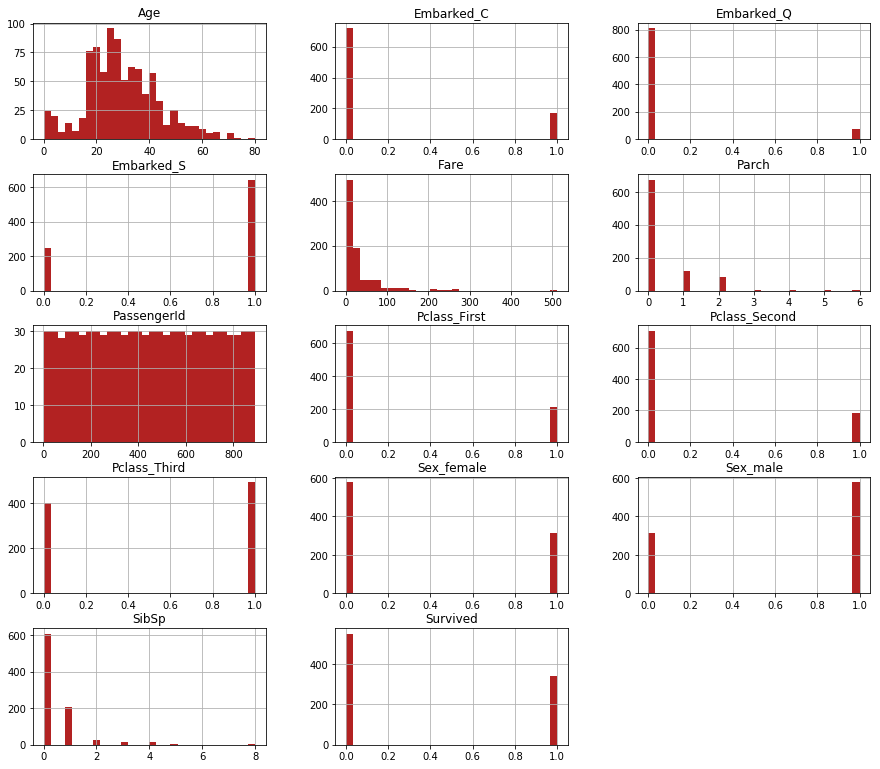

In [51]:
# bins --> max number of blocks in the graph
train_df_num.hist(color='firebrick', bins=30, layout=(11,3), figsize=(15,30));

There is a peak in the age because we have filled the empty fields with the same value (the average).  
++ v1.1 ++  
The peak has disappeared

Distribution graphics for each variable.

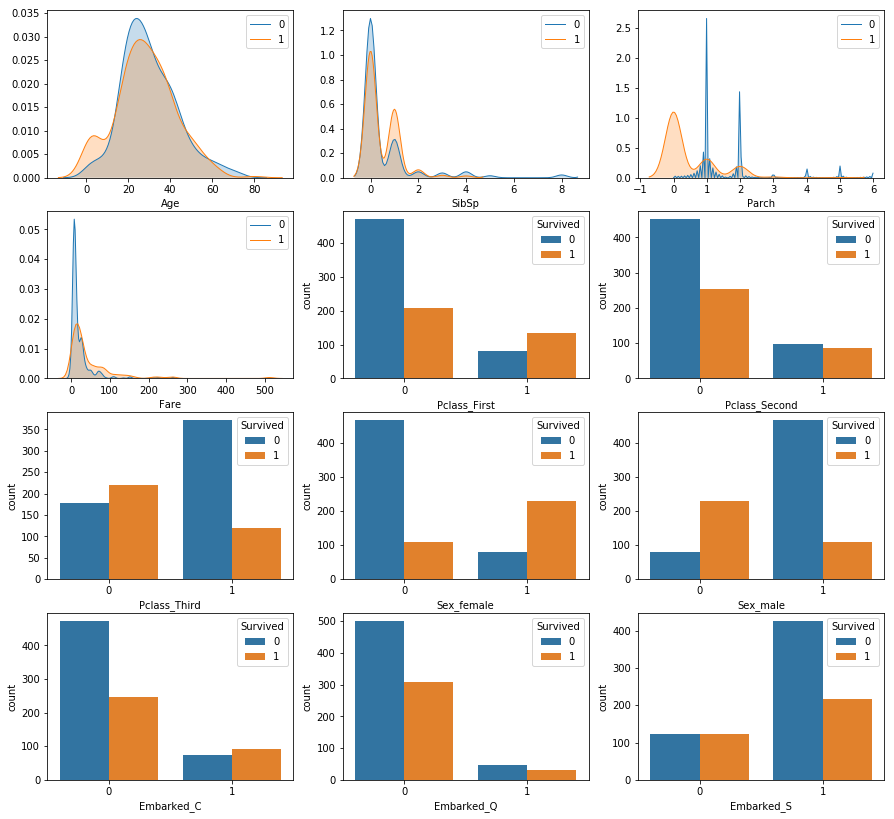

In [52]:
clases = np.unique(train_df_num["Survived"])
cols = list(train_df_num.columns)
cols.remove("Survived")
cols.remove("PassengerId")

plt.figure(figsize=(15,40))

for i,col in enumerate(cols):
    plt.subplot(11,3,i+1)
    if len(np.unique(train_df_num[col]))>2:
        for c in clases:
            sns.distplot(train_df_num[train_df_num["Survived"]==c][col], hist=False, kde=True,
                         kde_kws = {'shade': True, 'linewidth': 1}, 
                         label = c)
    else:
        sns.countplot(x=col, hue="Survived", data=train_df_num)

- There is a peak of Survived=0 in Pclass_Third=1. It was less likely to survive in third class.
- There is a peak of Survived=1 in Parch=0
- There is a peak of Survived=0 in Parch=1
- There is a peak of Survived=0 in Sex_male=1. It was more likely to survive if you were a woman.
- There is a peak of Survived=0 in Embarked_S=1. It was less likely to survive if you embarked in Southamptom.

Calculate the correlation between parameters and generate a heatmap

In [53]:
corr = train_df_num.corr()
corr.shape

(14, 14)

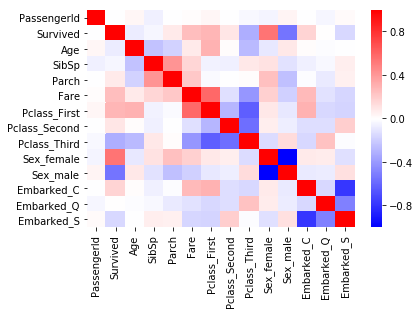

In [54]:
sns.heatmap(corr, cmap="bwr", vmax=1, vmin=-1);

- As expected, Fare and Pclass are related (Pclass_First=1 -> high Fare, Pclass_Third=1 -> low Fare).
- As we saw in the distribution graphics, Sex_male and Sex_female are related with Survived.
- As we saw in the distribution graphics, Pclass (and therefore Fare) are related with Survived.
- Parch and SibSp are also related. If you travel with your children, it's very likely that you also travel with your siblings/spouse (and vice versa)

Generate a hierarchically-clustered heatmap

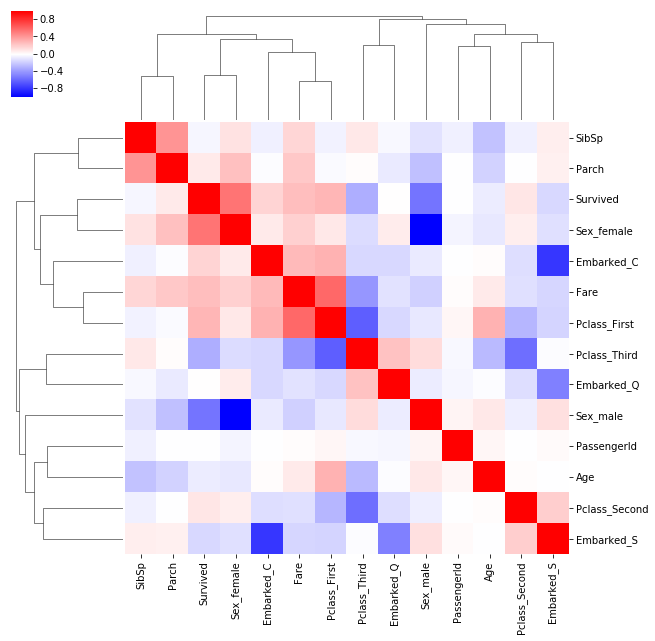

In [55]:
# Variables ordered by their equality in behaviour
sns.clustermap(corr, cmap="bwr", vmax=1, vmin=-1);

Variables more related are
- Sex_Female and Survived
- SibSp and Parch

In [56]:
# Ranking with variables sorted from more correlated with the target to less correlated (in absulute value)
corr["Survived"].abs().sort_values()[::-1] # Sort descendant with stride -1 [begin:end:step]

Survived         1.000000
Sex_male         0.541585
Sex_female       0.541585
Pclass_Third     0.320171
Pclass_First     0.282368
Fare             0.255290
Embarked_C       0.169966
Embarked_S       0.151777
Pclass_Second    0.095002
Parch            0.083151
Age              0.070487
SibSp            0.034040
PassengerId      0.005028
Embarked_Q       0.004536
Name: Survived, dtype: float64

As we saw in the correlation matrix Sex and Pclass are the most related variables to Survived.

++ v1.1 ++  
Add noise variables to create a more generic model.

In [57]:
train_df_num.shape

(889, 14)

In [58]:
train_df_num["x1"] = np.random.randn(len(train_df_num))
train_df_num["x2"] = np.random.randn(len(train_df_num))
train_df_num["x3"] = np.random.randn(len(train_df_num))

In [59]:
train_df_num.shape

(889, 17)

In [60]:
corr2 = train_df_num.corr()
corr2["Survived"].abs().sort_values()[::-1]

Survived         1.000000
Sex_male         0.541585
Sex_female       0.541585
Pclass_Third     0.320171
Pclass_First     0.282368
Fare             0.255290
Embarked_C       0.169966
Embarked_S       0.151777
Pclass_Second    0.095002
Parch            0.083151
Age              0.070487
SibSp            0.034040
x3               0.033178
x1               0.030212
x2               0.009001
PassengerId      0.005028
Embarked_Q       0.004536
Name: Survived, dtype: float64

++ v1.1 ++  
We also include these noise variables in test dataset

In [61]:
test_df_num.shape

(418, 13)

In [62]:
test_df_num["x1"] = np.random.randn(len(test_df_num))
test_df_num["x2"] = np.random.randn(len(test_df_num))
test_df_num["x3"] = np.random.randn(len(test_df_num))

In [63]:
test_df_num.shape

(418, 16)

### Defining matrix "X" and target "y"

For the training and test datasets we remove the ID and the target variable.

In [64]:
# Convert the training dataframe into an array
X      = train_df_num.drop(["PassengerId","Survived"], axis=1).values
y      = train_df_num["Survived"].values
IDs_train = train_df_num["PassengerId"].values

# Test:
X_test = test_df_num.drop(["PassengerId"], axis=1).values
IDs_test = test_df_num["PassengerId"].values

### Training-validation split

In [65]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3,
                                          random_state=1)
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((622, 15), (267, 15), (622,), (267,))

As we can see, data is not standardized (stardard deviation!=0)

In [66]:
X_tr.std(axis=0)

array([13.86139743,  1.10209795,  0.83750794, 40.13830573,  0.4207706 ,
        0.40774253,  0.49644886,  0.4755827 ,  0.4755827 ,  0.38689569,
        0.27435492,  0.44147863,  0.96507863,  1.000564  ,  0.99006276])

### Data standardization

There are models (like neuronal networks) that need standardized data.  
We use Standar Scaler --> X_standardized = (X - X_mean)/X_std  
Normalization (values between 0 and 1). Standardization (Mean=0, Standard deviation=1)

In [67]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
#sc.fit(X_tr)
sc.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [68]:
#X_tr_sc = sc.transform(X_tr) # Training
#X_te_sc = sc.transform(X_te) # Validation
# If we fit and transforms using the same dataset, we can use fit_transform
X_sc = sc.transform(X) # Training
X_test_sc = sc.transform(X_test) # Test

categorical = []
#for i in range(X_tr.shape[1]):
#    if len(np.unique(X_tr[:,i]))<=2: # Columns with 2 or less different values
#        categorical.append(i)
for i in range(X.shape[1]):
    if len(np.unique(X[:,i]))<=2: # Columns with 2 or less different values
        categorical.append(i)

# Categorical variables are not standardized. Values recovered from pre-standardized data
#X_tr_sc[:,categorical]   = X_tr[:,categorical]
#X_te_sc[:,categorical]   = X_te[:,categorical]
X_sc[:,categorical]   = X[:,categorical]
X_test_sc[:,categorical] = X_test[:,categorical]

print(categorical) # Categorical columns are not standardized
X_sc.std(axis=0) # Standardized variables has standard deviation = 1

[4, 5, 6, 7, 8, 9, 10, 11]


array([1.        , 1.        , 1.        , 1.        , 0.42752057,
       0.40513681, 0.49725656, 0.47726924, 0.47726924, 0.39148985,
       0.28126884, 0.44681137, 1.        , 1.        , 1.        ])

In [69]:
X_sc

array([[-0.55186579,  0.43135024, -0.47432585, ...,  1.26283019,
         1.18321773,  1.4035116 ],
       [ 0.63050189,  0.43135024, -0.47432585, ...,  0.54394072,
        -1.7429007 ,  0.1798726 ],
       [-0.25627387, -0.47519908, -0.47432585, ..., -0.38955881,
        -1.39189562, -1.08561976],
       ...,
       [-0.77355973,  0.43135024,  2.00611934, ..., -1.33655944,
        -0.78572752,  0.57661219],
       [-0.25627387, -0.47519908, -0.47432585, ..., -0.18170938,
         0.20655769,  0.29369071],
       [ 0.18711401, -0.47519908, -0.47432585, ...,  1.47457083,
         0.21517276,  0.27599708]])

In [70]:
X_sc.mean(axis=0)

array([-1.99815168e-17, -3.19704268e-17, -4.79556402e-17,  1.39870617e-16,
        2.40719910e-01,  2.06974128e-01,  5.52305962e-01,  3.50956130e-01,
        6.49043870e-01,  1.88976378e-01,  8.66141732e-02,  7.24409449e-01,
        1.19889101e-17,  3.19704268e-17, -3.19704268e-17])

In [71]:
X_sc.std(axis=0)

array([1.        , 1.        , 1.        , 1.        , 0.42752057,
       0.40513681, 0.49725656, 0.47726924, 0.47726924, 0.39148985,
       0.28126884, 0.44681137, 1.        , 1.        , 1.        ])

### PCA visualization

We use this kind of visualization to see if the points cloud of target=0 and target=1 are overlapped (complex problem) or not (simple problem). We use it only with numerical variables.

In [72]:
from sklearn.decomposition import PCA
pca = PCA() # You can use the parameter n_components to keep only the first n components.
num_columns=range(0,4) # Numeric columns (number 1,2,3 and 4). Categorical converted into numerical (0 or 1) are not included.
pca.fit(X_sc[:,num_columns])

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [73]:
X_pca = pca.transform(X_sc[:,num_columns]) # Only transform (already fit) and with numeric columns.
X_test_pca = pca.transform(X_test_sc[:,num_columns])

X_sc.shape, X_pca.shape, X_test_sc.shape, X_test_pca.shape

((889, 15), (889, 4), (418, 15), (418, 4))

In [74]:
X_pca

array([[ 1.55822837e-02, -8.13491423e-01,  8.57471803e-02,
        -5.44499792e-01],
       [-1.56415007e-04,  9.23108956e-01,  1.23395197e-01,
        -7.50773523e-01],
       [-6.50617969e-01, -5.37387052e-01,  1.90328691e-01,
         7.06402270e-02],
       ...,
       [ 1.72913755e+00, -4.90903314e-01, -4.97886314e-01,
         1.16639799e+00],
       [-5.08315093e-01, -2.15164472e-01,  4.60036278e-01,
         4.40910589e-02],
       [-8.12440663e-01, -2.39219876e-01, -9.10708067e-02,
         2.23773934e-02]])

In [75]:
X[:,num_columns]

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [19.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

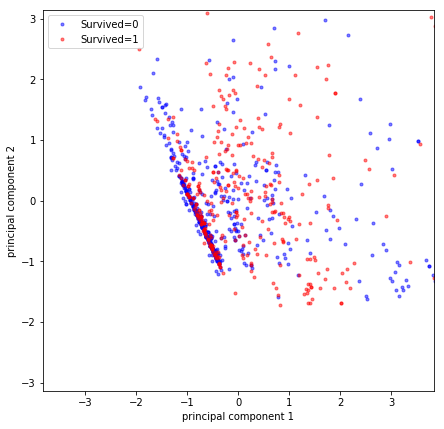

In [76]:
# You can change which PCA components you want to display (0 and 1, 1 and 2,...)
comp_horiz=0
comp_vert =1

plt.figure(figsize=(7,7))
plt.plot(X_pca[y==0,comp_horiz],
         X_pca[y==0,comp_vert], '.', label="Survived=0",
         alpha=0.5, color="blue")
plt.plot(X_pca[y==1,comp_horiz],
         X_pca[y==1,comp_vert], '.', label="Survived=1",
         alpha=0.5, color="red")
m_horiz   = X_pca[:,comp_horiz].mean()
std_horiz = X_pca[:,comp_horiz].std()
m_vert    = X_pca[:,comp_vert].mean()
std_vert  = X_pca[:,comp_vert].std()
plt.axis([m_horiz-3*std_horiz, m_horiz+3*std_horiz,
          m_vert-3*std_vert,   m_vert+3*std_vert])
plt.xlabel('principal component '+str(comp_horiz+1))
plt.ylabel('principal component '+str(comp_vert+1))
plt.legend();

## Dummy classifier (baseline)

The dummy classifier is based on simple rules. Real classifiers should be better than these ones. There are several strategies to follow:
    - Most frequent: Just take the most frequent label in the training dataset.
    - Stratified: Generates predictions by respecting the training dataset’s class distribution.

In [77]:
from sklearn.dummy import DummyClassifier

clf_dummy = DummyClassifier(strategy='most_frequent')
clf_dummy.fit(X,y)

print("Scoring training:", clf_dummy.score(X, y))
print("Scoring test    :", clf_dummy.score(X_te, y_te))

Scoring training: 0.6175478065241845
Scoring test    : 0.6217228464419475


In [78]:
clf_dummy = DummyClassifier(strategy='stratified')
clf_dummy.fit(X,y)

print("Scoring training:", clf_dummy.score(X, y))
print("Scoring test    :", clf_dummy.score(X_te, y_te))

Scoring training: 0.5174353205849269
Scoring test    : 0.5580524344569289


## Logistic Regression

In [83]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression()

# We will probably have more training examples with Survived=0 than examples with Survived=1. That's why we use StratifiedKFold
# because it will ensure that each set contains approximately the same percentage of samples of each target class as the 
# complete set
kfolds=10
cv = StratifiedKFold(n_splits = kfolds) 

params = {
    # lower C values means increase the regularization strength (more simple models -->underfit),
    # bigger C values means decrease the regularization strength (more complex models -->overfit)
    "C" : [0.001, 0.01, 0.1, 1, 1.1, 10],
    "solver" : ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "max_iter" : [1000, 10000]}

# n_jobs=-1 --> Uses all processors
# return_train_score=True --> cv_results_ attribute includes training scores
grid = GridSearchCV(clf_lr, params, cv = cv, verbose = 0, n_jobs = -1, return_train_score=True)
grid = grid.fit(X_sc, y)

print(grid.best_params_)

clf_lr = grid.best_estimator_

{'C': 0.1, 'max_iter': 1000, 'solver': 'newton-cg'}


In [84]:
print("Accuracy Train: %0.2f (+/- %0.2f)" % (grid.cv_results_['mean_train_score'].mean(), grid.cv_results_['std_train_score'].mean() * 2))
print("Accuracy Test: %0.2f (+/- %0.2f)" % (grid.cv_results_['mean_test_score'].mean(), grid.cv_results_['std_test_score'].mean() * 2))

Accuracy Train: 0.78 (+/- 0.01)
Accuracy Test: 0.77 (+/- 0.05)


## Neural network

In [90]:
from sklearn.neural_network import MLPClassifier # Multi-layer Perceptron

clf_nn = MLPClassifier()

# We will probably have more training examples with Survived=0 than examples with Survived=1. That's why we use StratifiedKFold
# because it will ensure that each set contains approximately the same percentage of samples of each target class as the 
# complete set
kfolds=5
cv = StratifiedKFold(n_splits = kfolds) 

params = {
    # lower C values means increase the regularization strength (more simple models -->underfit),
    # bigger C values means decrease the regularization strength (more complex models -->overfit)
    # Number of elements in the hidden layer. Number of hidden layers can also be selected
    "hidden_layer_sizes" : np.arange(5, 10),
    "activation" : ["logistic", "relu"],
    "solver" : ["lbfgs", "sgd", "adam"],
    # alpha -> L2 penalty (regularization term) parameter.
    # L2 -> Ridge (cost function is altered by adding a penalty equivalent to square of the magnitude of the coefficients)
    # higher the alpha value, more restriction on the coefficients -> shrinks the coefficients -> reduce the model complexity
    # low alpha -> more generalization, coefficients are barely restricted.
    "alpha" : 10.0 ** -np.arange(1, 5),
    "learning_rate" : ["constant", "invscaling", "adaptive"],
    "learning_rate_init" : 10.0 ** -np.arange(1, 4),
    "max_iter" : [200, 1000, 2000],
    "random_state" : [1]}

# n_jobs=-1 --> Uses all processors
# return_train_score=True --> cv_results_ attribute includes training scores
grid = GridSearchCV(clf_nn, params, cv = cv, verbose = 3, n_jobs = -1, return_train_score=True)
grid = grid.fit(X_sc, y)

print(grid.best_params_)

clf_nn = grid.best_estimator_

Fitting 5 folds for each of 3240 candidates, totalling 16200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1168 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1584 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2064 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2608 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 3216 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 3888 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 4624 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 5424 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 6288 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 7216 tasks      | e

{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 8, 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 1000, 'random_state': 1, 'solver': 'adam'}


In [91]:
print("Accuracy Train: %0.2f (+/- %0.2f)" % (grid.cv_results_['mean_train_score'].mean(), grid.cv_results_['std_train_score'].mean() * 2))
print("Accuracy Test: %0.2f (+/- %0.2f)" % (grid.cv_results_['mean_test_score'].mean(), grid.cv_results_['std_test_score'].mean() * 2))

Accuracy Train: 0.82 (+/- 0.02)
Accuracy Test: 0.75 (+/- 0.05)


Neural network without Cross Validation

In [80]:
from sklearn.neural_network import MLPClassifier # Multi-layer Perceptron
from sklearn.metrics import log_loss # log-loss is based on how much the prediction varies from the actual label.

N_iters = 1000
architecture = (5,) # one single hidden layer with 5 neurons.

X_tr1_sc, X_tr2_sc, y_tr1, y_tr2 = train_test_split(X_tr_sc, y_tr,
                                                    test_size=0.3,
                                                    random_state=1)

# X_tr2, y_tr2 is the validation dataset to avoid overfitting in training.
clf_nn = MLPClassifier(verbose=True, max_iter=1, random_state=7,
                       hidden_layer_sizes=architecture,
                       early_stopping=False, warm_start=True)
# max_iter -> number of epochs (solver is 'adam')
# early_stopping -> finish if validation score is not improving
best_loss_in_val = 1e20
for i in range(N_iters):
    clf_nn.fit(X_tr1_sc, y_tr1)
    loss_val = log_loss(y_tr2, clf_nn.predict_proba(X_tr2_sc))
    if loss_val < best_loss_in_val:
        best_weights = clf_nn.coefs_.copy()
        best_loss_in_val = loss_val
        print("nnet improvement in validation")

clf_nn.coefs_ = best_weights
print("Scoring training:", clf_nn.score(X_tr_sc, y_tr))
print("Scoring test    :", clf_nn.score(X_te_sc, y_te))

Iteration 1, loss = 0.78793602
nnet improvement in validation
Iteration 2, loss = 0.78294989
nnet improvement in validation
Iteration 3, loss = 0.77827265
nnet improvement in validation
Iteration 4, loss = 0.77383832
nnet improvement in validation
Iteration 5, loss = 0.76954771
nnet improvement in validation
Iteration 6, loss = 0.76537228
nnet improvement in validation
Iteration 7, loss = 0.76127904
nnet improvement in validation
Iteration 8, loss = 0.75726745
nnet improvement in validation
Iteration 9, loss = 0.75332687
nnet improvement in validation
Iteration 10, loss = 0.74948145
nnet improvement in validation
Iteration 11, loss = 0.74572634
nnet improvement in validation
Iteration 12, loss = 0.74207693
nnet improvement in validation
Iteration 13, loss = 0.73850130
nnet improvement in validation
Iteration 14, loss = 0.73498878
nnet improvement in validation
Iteration 15, loss = 0.73153642
nnet improvement in validation
Iteration 16, loss = 0.72816414
nnet improvement in validation
I

C:\Users\albher\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 44, loss = 0.65718664
nnet improvement in validation
Iteration 45, loss = 0.65511594
nnet improvement in validation
Iteration 46, loss = 0.65305278
nnet improvement in validation
Iteration 47, loss = 0.65100721
nnet improvement in validation
Iteration 48, loss = 0.64898276
nnet improvement in validation
Iteration 49, loss = 0.64697635
nnet improvement in validation
Iteration 50, loss = 0.64496664
nnet improvement in validation
Iteration 51, loss = 0.64296234
nnet improvement in validation
Iteration 52, loss = 0.64097230
nnet improvement in validation
Iteration 53, loss = 0.63898348
nnet improvement in validation
Iteration 54, loss = 0.63699250
nnet improvement in validation
Iteration 55, loss = 0.63500897
nnet improvement in validation
Iteration 56, loss = 0.63301753
nnet improvement in validation
Iteration 57, loss = 0.63102923
nnet improvement in validation
Iteration 58, loss = 0.62905735
nnet improvement in validation
Iteration 59, loss = 0.62708782
nnet improvement in va

Iteration 200, loss = 0.46477280
nnet improvement in validation
Iteration 201, loss = 0.46440608
nnet improvement in validation
Iteration 202, loss = 0.46403649
nnet improvement in validation
Iteration 203, loss = 0.46366811
nnet improvement in validation
Iteration 204, loss = 0.46330142
nnet improvement in validation
Iteration 205, loss = 0.46293790
nnet improvement in validation
Iteration 206, loss = 0.46257606
nnet improvement in validation
Iteration 207, loss = 0.46221699
nnet improvement in validation
Iteration 208, loss = 0.46186140
nnet improvement in validation
Iteration 209, loss = 0.46151415
nnet improvement in validation
Iteration 210, loss = 0.46117959
nnet improvement in validation
Iteration 211, loss = 0.46085306
nnet improvement in validation
Iteration 212, loss = 0.46053369
nnet improvement in validation
Iteration 213, loss = 0.46022027
nnet improvement in validation
Iteration 214, loss = 0.45991626
nnet improvement in validation
Iteration 215, loss = 0.45962211
nnet im

Iteration 429, loss = 0.42460521
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 430, loss = 0.42451896
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 431, loss = 0.42444112
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 432, loss = 0.42434940
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 433, loss = 0.42424658
Iteration 434, loss = 0.42415200
Iteration 435, loss = 0.42407403
Iteration 436, loss = 0.42401142
Iteration 437, loss = 0.42393866
Iteration 438, loss = 0.42385394
Iteration 439, loss = 0.42376774
Iteration 440, loss = 0.42367530
Iteration 441, loss = 0.42358618
Iteration 442, loss = 0.42350190
Iteration 443, loss = 0.42341918
Iteration 444, loss = 0.42334099
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 445, loss = 

Iteration 543, loss = 0.41531147
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 544, loss = 0.41525469
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 545, loss = 0.41519154
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 546, loss = 0.41511408
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 547, loss = 0.41504216
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 548, loss = 0.41497782
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 549, loss = 0.41492938
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 550, loss = 0.41487636
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 551, l

Iteration 653, loss = 0.40791898
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 654, loss = 0.40784323
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 655, loss = 0.40777816
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 656, loss = 0.40769523
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 657, loss = 0.40759516
Iteration 658, loss = 0.40750294
Iteration 659, loss = 0.40743066
Iteration 660, loss = 0.40736617
Iteration 661, loss = 0.40728216
Iteration 662, loss = 0.40719129
Iteration 663, loss = 0.40709629
Iteration 664, loss = 0.40703712
Iteration 665, loss = 0.40697086
Iteration 666, loss = 0.40688571
Iteration 667, loss = 0.40678586
Iteration 668, loss = 0.40668778
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 669, loss = 

Iteration 824, loss = 0.39364005
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 825, loss = 0.39355813
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 826, loss = 0.39347049
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 827, loss = 0.39341595
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 828, loss = 0.39336324
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 829, loss = 0.39328910
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 830, loss = 0.39320981
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 831, loss = 0.39314606
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 832, l

Iteration 934, loss = 0.38814790
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 935, loss = 0.38810548
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 936, loss = 0.38804656
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 937, loss = 0.38799848
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 938, loss = 0.38796431
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 939, loss = 0.38793612
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 940, loss = 0.38790194
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 941, loss = 0.38783700
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 942, l

## SVM (Support Vector Machines)

Uses a hyperplane to separate the different classes. This hyperplane is the one that has the largest separation between the two classes.
If the two classes are not linearly separable, it adds dimensions by operating with the existing ones (kernel function), so that in this new space the two classes were separable.

In [81]:
from sklearn.svm import SVC

clf_svm = SVC() # Support Vector Classification

# We will probably have more training examples with Survived=0 than examples with Survived=1. That's why we use StratifiedKFold
# because it will ensure that each set contains approximately the same percentage of samples of each target class as the 
# complete set
kfolds=10
cv = StratifiedKFold(n_splits = kfolds) 

params = {
    # lower C values means increase the regularization strength (more simple models -->underfit),
    # bigger C values means decrease the regularization strength (more complex models -->overfit)
    "C" : [0.001, 0.01, 0.1, 1, 1.1, 10],
    "kernel" : ["linear", "poly", "rbf", "sigmoid"],
    "gamma" : ["auto", "scale"]}

# n_jobs=-1 --> Uses all processors
# return_train_score=True --> cv_results_ attribute includes training scores
grid = GridSearchCV(clf_svm, params, cv = cv, verbose = 0, n_jobs = -1, return_train_score=True)
grid = grid.fit(X_sc, y)

print(grid.best_params_)

clf_svm = grid.best_estimator_

{'C': 1, 'gamma': 'scale', 'kernel': 'poly'}


In [82]:
print("Accuracy Train: %0.2f (+/- %0.2f)" % (grid.cv_results_['mean_train_score'].mean(), grid.cv_results_['std_train_score'].mean() * 2))
print("Accuracy Test: %0.2f (+/- %0.2f)" % (grid.cv_results_['mean_test_score'].mean(), grid.cv_results_['std_test_score'].mean() * 2))

Accuracy Train: 0.74 (+/- 0.01)
Accuracy Test: 0.73 (+/- 0.05)


## Random Forest

Constructs a large number of decision trees at training time and outputs the most frequent class (mode) for classification problems.

In [83]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier()

# We will probably have more training examples with Survived=0 than examples with Survived=1. That's why we use StratifiedKFold
# because it will ensure that each set contains approximately the same percentage of samples of each target class as the 
# complete set
kfolds=10
cv = StratifiedKFold(n_splits = kfolds) 

params = {
    # n_estimators --> number of trees in the forest
    "n_estimators" : [200, 300, 400, 500, 1000],
    # max_depth --> maximum depth of the tree
    "max_depth" : [1, 3, 5, 7, 9]}

# n_jobs=-1 --> Uses all processors
# return_train_score=True --> cv_results_ attribute includes training scores
grid = GridSearchCV(clf_rf, params, cv = cv, verbose = 0, n_jobs = -1, return_train_score=True)
grid = grid.fit(X, y)

print(grid.best_params_)

clf_rf = grid.best_estimator_

{'max_depth': 7, 'n_estimators': 300}


In [84]:
print("Accuracy Train: %0.2f (+/- %0.2f)" % (grid.cv_results_['mean_train_score'].mean(), grid.cv_results_['std_train_score'].mean() * 2))
print("Accuracy Test: %0.2f (+/- %0.2f)" % (grid.cv_results_['mean_test_score'].mean(), grid.cv_results_['std_test_score'].mean() * 2))

Accuracy Train: 0.87 (+/- 0.01)
Accuracy Test: 0.81 (+/- 0.08)


## Gradient Boosting

Combines weak prediction models into a single strong learner. Unlike Random Forest (bagging) it gives more weight to misclassified examples (it's more likely that these examples appear in the next iteration's dataset).

In [85]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gb = GradientBoostingClassifier()

# We will probably have more training examples with Survived=0 than examples with Survived=1. That's why we use StratifiedKFold
# because it will ensure that each set contains approximately the same percentage of samples of each target class as the 
# complete set
kfolds=10
cv = StratifiedKFold(n_splits = kfolds) 

params = {
    "n_estimators" : [300, 500, 700],
    "learning_rate" : [0.005, 0.01, 0.1],
    "max_depth" : [3, 5], # maximum depth of the individual regression estimators
    "max_features" : [3, 5]} # the number of features to consider when looking for the best split

# n_jobs=-1 --> Uses all processors
# return_train_score=True --> cv_results_ attribute includes training scores
grid = GridSearchCV(clf_gb, params, cv = cv, verbose = 0, n_jobs = -1, return_train_score=True)
grid = grid.fit(X, y)

print(grid.best_params_)

clf_gb = grid.best_estimator_

{'learning_rate': 0.005, 'max_depth': 5, 'max_features': 3, 'n_estimators': 500}


In [86]:
print("Accuracy Train: %0.2f (+/- %0.2f)" % (grid.cv_results_['mean_train_score'].mean(), grid.cv_results_['std_train_score'].mean() * 2))
print("Accuracy Test: %0.2f (+/- %0.2f)" % (grid.cv_results_['mean_test_score'].mean(), grid.cv_results_['std_test_score'].mean() * 2))
grid.cv_results_['std_test_score']

Accuracy Train: 0.92 (+/- 0.01)
Accuracy Test: 0.82 (+/- 0.09)


array([0.04118715, 0.03898272, 0.04031129, 0.03909768, 0.04354457,
       0.03867994, 0.05106942, 0.04934192, 0.04110682, 0.05565813,
       0.04679114, 0.04784286, 0.03723569, 0.03793899, 0.03865307,
       0.04298892, 0.03834824, 0.03771461, 0.05045132, 0.04398026,
       0.04051973, 0.04576558, 0.04691772, 0.05269645, 0.03968868,
       0.04449943, 0.04281849, 0.03905288, 0.04895842, 0.04031562,
       0.03997416, 0.04277232, 0.04203471, 0.03849509, 0.04514401,
       0.04214142])

## Decision Trees

Create models that predicts the value of a target variable by learning simple decision rules inferred from the data features. Usually they do not generalise the data well, but on the other hand they are simple to understand and to interpret.

In [83]:
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier()

# We will probably have more training examples with Survived=0 than examples with Survived=1. That's why we use StratifiedKFold
# because it will ensure that each set contains approximately the same percentage of samples of each target class as the 
# complete set
kfolds=10
cv = StratifiedKFold(n_splits = kfolds) 

#MIRAR QUE PARAMETROS PONER
params = {
    "criterion" : ['gini', 'entropy'], # function to measure the quality of a split
    "splitter" : ['best', 'random'], # strategy used to choose the split at each node
    "min_samples_leaf" : [1, 10, 20, 50]} # strategy used to choose the split at each node

# n_jobs=-1 --> Uses all processors
# return_train_score=True --> cv_results_ attribute includes training scores
grid = GridSearchCV(clf_dt, params, cv = cv, verbose = 0, n_jobs = -1, return_train_score=True)
grid = grid.fit(X, y)

print(grid.best_params_)

clf_dt = grid.best_estimator_

{'criterion': 'entropy', 'min_samples_leaf': 10, 'splitter': 'random'}


In [84]:
print("Accuracy Train: %0.2f (+/- %0.2f)" % (grid.cv_results_['mean_train_score'].mean(), grid.cv_results_['std_train_score'].mean() * 2))
print("Accuracy Test: %0.2f (+/- %0.2f)" % (grid.cv_results_['mean_test_score'].mean(), grid.cv_results_['std_test_score'].mean() * 2))
grid.cv_results_['std_test_score']

Accuracy Train: 0.87 (+/- 0.01)
Accuracy Test: 0.79 (+/- 0.09)


array([0.03470843, 0.05529441, 0.06010549, 0.04259565, 0.05426469,
       0.02759692, 0.03084823, 0.05031868, 0.0564286 , 0.04022951,
       0.05556268, 0.03817509, 0.05618975, 0.03232543, 0.03084823,
       0.04716596])

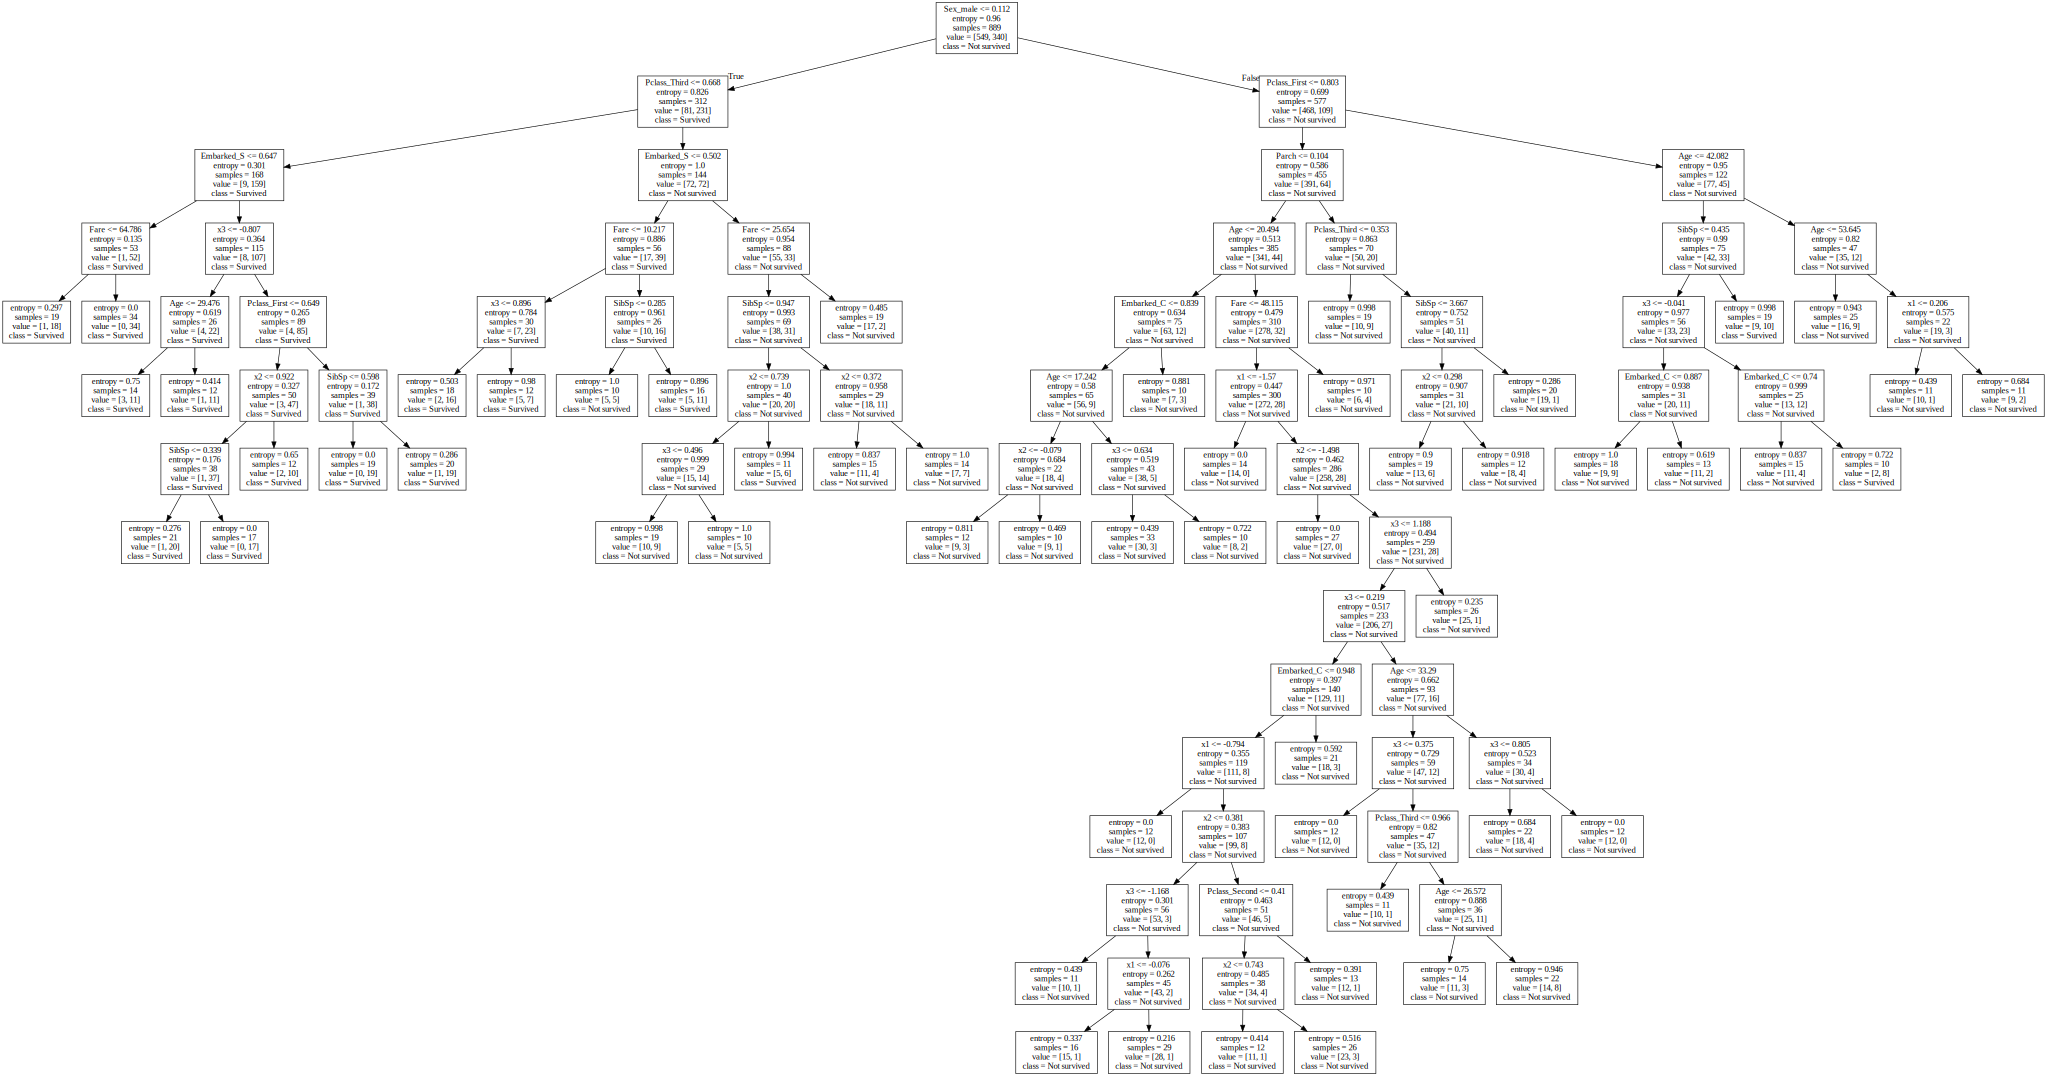

In [85]:
# In newer versions of sklearn (from 0.21) we can use sklearn.tree.plot_tree or export_text
from sklearn.tree import export_graphviz
import graphviz
dot_data = export_graphviz(clf_dt, out_file=None,
                           feature_names=train_df_num.drop(["PassengerId","Survived"], axis=1).columns,
                           class_names=['Not survived','Survived'], label='all')
graph = graphviz.Source(dot_data)
graph
# Value = [elements category 1 (Not Survived), elements category 2 (Survived)] --> addition=samples
# class -> class with greatest number of samples
# gini = 0 --> all the elements belong to one class
# gini = 0.5 --> elements even distributed among classes (50% Survived, 50% Not Survived, in our example)
# Always chooses the variable with the lowest gini in the root. And then the lowest of the rest of variables in the next level.
# Example: 1 - (((383/622)^2) + ((239/622)^2)) = 0.473

# Predictions in test dataset

Choose one model

In [92]:
opcion = 2

# 1: logistic regression
# 2: neural network
# 3: SVM
# 4: random forest
# 5: gradient boosting
# 6: decision tree

if opcion == 1:
    clf = clf_lr
    X_test_aux = X_test_sc
    model="lr"
if opcion == 2:
    clf = clf_nn
    X_test_aux = X_test_sc
    model="nn"
if opcion == 3:
    clf = clf_svm
    X_test_aux = X_test_sc
    model="svm"
elif opcion == 4:
    clf = clf_rf
    X_test_aux = X_test
    model="rf"
elif opcion == 5:
    clf = clf_gb
    X_test_aux = X_test
    model="gb"
elif opcion == 6:
    clf = clf_dt
    X_test_aux = X_test
    model="dt"

In [93]:
#prob_surv_test=clf.predict_proba(X_test_aux) # Returns the probability between 0 and 1
prob_surv_test=clf.predict(X_test_aux) # Returns 0 or 1

In [94]:
predictions = pd.DataFrame({"PassengerId":IDs_test,
                             "Survived":prob_surv_test})
predictions[:5]

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [95]:
predictions.shape

(418, 2)

In [96]:
version="1.2"
predictions.to_csv('gender_submission_'+model+'_v'+version+'.csv',index=False)

### Results:

v1
* **Regresión Logística:** 0.76076 ---> 76% de acierto (100 fallos)
* **Neural Network:** 0.75598 ---> 76% de acierto (102 fallos)
* **SVM:** 0.78468 ---> 78% de acierto (90 fallos)
* **Random Forest (RF):** 0.73684 ---> 74% de acierto (110 fallos)
* **Gradient Boosting (GB):** 0.78468 ---> 78% de acierto (90 fallos)
* **Decision Tree:** 0.68899 ---> 69% de acierto (130 fallos)

v1.1
* **Regresión Logística:** 0.75598 ---> 76% de acierto (102 fallos)
* **Regresión Logística:** 0.74641 ---> 75% de acierto (106 fallos)
* **Neural Network:** 0.76555 ---> 76% de acierto (98 fallos)
* **Neural Network:** 0.75119 ---> 75% de acierto (104 fallos)
* **SVM:** 0.77990 ---> 78% de acierto (92 fallos)
* **SVM:** 0.77511 ---> 77% de acierto (94 fallos)
* **Random Forest (RF):** 0.74641 ---> 75% de acierto (106 fallos)
* **Random Forest (RF):** 0.76555 ---> 76% de acierto (98 fallos)
* **Gradient Boosting (GB):** 0.77511 ---> 77% de acierto (94 fallos)
* **Gradient Boosting (GB):** 0.76555 ---> 76% de acierto (98 fallos)
* **Decision Tree:** 0.67464 ---> 67% de acierto (136 fallos)
* **Decision Tree:** 0.66507 ---> 66% de acierto (140 fallos)

v1.2
* **Regresión Logística:** 0.77511 ---> 77% de acierto (94 fallos)
* **Neural Network:** 0.76076 ---> 76% de acierto (100 fallos)
* **SVM:** 0.77511 ---> 77% de acierto (94 fallos)
* **Random Forest (RF):** 0.77990 ---> 78% de acierto (92 fallos)
* **Gradient Boosting (GB):** 0.77272 ---> 77% de acierto (95 fallos)
* **Gradient Boosting (GB): 0.79904** ---> 80% de acierto (84 fallos) --> cross_validate and taking the last one.
* **Decision Tree:** 0.77990 ---> 78% de acierto (92 fallos)